<a href="https://www.kaggle.com/code/supaseksamurai88/1store-sales-trend-prediction?scriptVersionId=152962269" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

train_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,)


train_data

/tmp/ipykernel_19/1246566190.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  train_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv',


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0
1,1,2013-01-01,1,BABY CARE,0.000000,0
2,2,2013-01-01,1,BEAUTY,0.000000,0
3,3,2013-01-01,1,BEVERAGES,0.000000,0
4,4,2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.132996,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8


In [3]:
train_data = train_data.set_index('date').to_period('D')
train_data = train_data.set_index(['store_nbr', 'family'], append=True)

In [4]:
train_data.head()

id  sales  onpromotion
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE   0    0.0            0
                     BABY CARE    1    0.0            0
                     BEAUTY       2    0.0            0
                     BEVERAGES    3    0.0            0
                     BOOKS        4    0.0            0

In [5]:
average_sales = train_data.groupby('date').mean()['sales']

In [6]:
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
Freq: D, Name: sales, dtype: float32

## Trend Engineering

Ref.https://medium.com/@thedatabeast/time-series-part-4-determining-the-window-size-for-moving-averages-a07c5cfcfac9#:~:text=Rule%20of%20thumb%3A%20A%20commonly,data%20points%20might%20be%20appropriate.

This blog said that the perfect window size should be around 10% - 25% of our total data entries, which are 5 years (1825 days)

I will be determining the best result of linear regression model with the different size of the window for calculating the average value.

Our candidates are:
- 365 (Default)
- 457 (25% of total date in our data)
- 183 (10% of total date in our data)

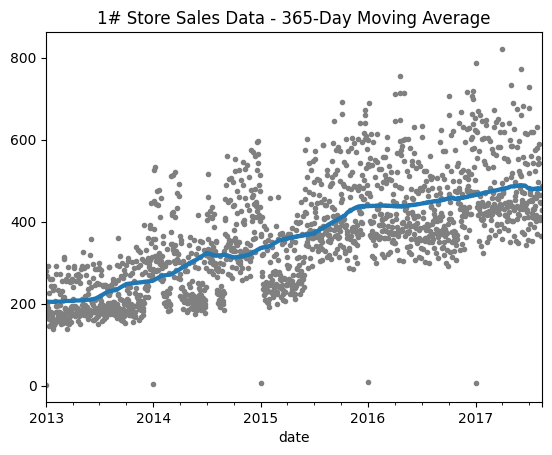

In [7]:
moving_average = average_sales.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = average_sales.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="1# Store Sales Data - 365-Day Moving Average", legend=False,
);

In [8]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()  # the target

# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index = average_sales.index,
    order = 2,
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

# YOUR CODE HERE: Create features for a 16-day forecast.
X_fore = dp.out_of_sample(steps = 16)



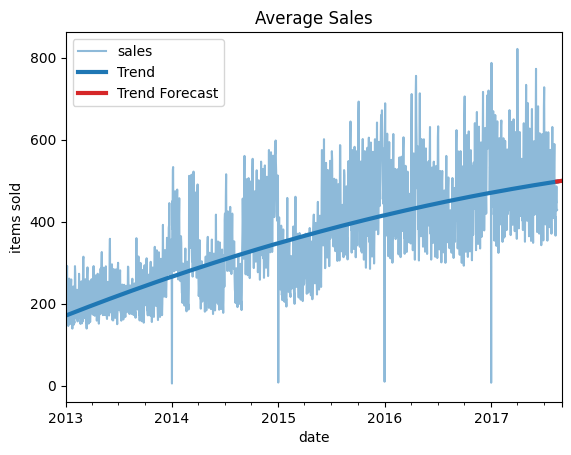

In [9]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

In [10]:
if type(y) == pd.DataFrame:
    print("y is a DataFrame")
elif type(y) == pd.Series:
    print("y is a Series")
else:
    print("y is neither a DataFrame nor a Series")


y is a Series


In [11]:
test_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv',
                       dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True)
test_data['date'] = test_data.date.dt.to_period('D')
test_data = test_data.set_index(['store_nbr', 'family', 'date']).sort_index()

test_data.head()

/tmp/ipykernel_19/2572057167.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  test_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv',


id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0

In [12]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
# X_test['NewYear'] = (X_test.index.dayofyear == 1)


# y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y)
# y_submit = y_submit.stack(['store_nbr', 'family'])
# y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
# y_submit.to_csv('submission.csv', index=False)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=['sales'])
y_submit = y_submit.join(test_data.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

## This one is from ChatGPT ;), the explanation of the last 3 lines

In this modification:

The columns parameter in pd.DataFrame() is set directly to ['sales'] assuming that the predicted values represent sales.
Make sure that the column name you use in columns=['sales'] matches the expected column name in your submission file. Adjust the column names and structure based on your specific requirements.

If you have more than one series or value to predict, you might need to create a separate DataFrame for each and concatenate them if needed. If you have further questions or if the structure of your data is more complex, please provide additional details for more targeted assistance.